## Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import bcolz
import time
%matplotlib inline

In [2]:
torch.__version__

'1.0.1.post2'

In [3]:
import sys
sys.version

'3.7.1 (default, Dec 14 2018, 19:28:38) \n[GCC 7.3.0]'

In [4]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [5]:
data_dir = './Dataset'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'val', 'test']}


In [6]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val','test']}
dset_sizes

{'train': 66071, 'val': 11016, 'test': 33154}

In [7]:
dset_classes = dsets['train'].classes

In [8]:
def shuffle_valtrain(x):
    if x == 'train' or 'test':
        return True
    else:
        return False

In [9]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'val', 'test']}

In [10]:
dataset_valid = torch.utils.data.DataLoader(dsets['val'], batch_size=5, shuffle=True, num_workers=6)

In [11]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
count = 1
for data in dataset_valid:
#     print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count +=1

In [13]:
labels_try

tensor([133,  33, 127, 132, 104])

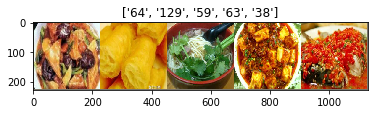

In [14]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

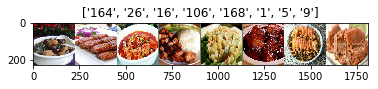

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

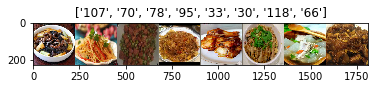

In [16]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['val']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

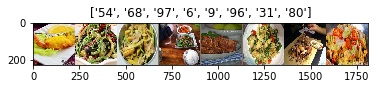

In [17]:
# Get a batch of test data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Creating VGG model

In [8]:
model_vgg = models.vgg16(pretrained=True)

In [9]:
# inputs_try , labels_try = gpu(inputs_try),gpu(labels_try)

model_vgg = gpu(model_vgg)

In [20]:
outputs_try = model_vgg(inputs_try)

In [21]:
outputs_try

tensor([[ 2.8248,  2.9959, -2.7206,  ...,  3.9608,  9.4240, -1.2522],
        [ 0.0865,  3.8611, -2.3998,  ...,  0.9513,  7.3523,  0.3353],
        [ 0.7386,  2.5518,  1.0972,  ...,  1.0347,  6.8626, -0.2532],
        [ 2.2731,  2.6609, -2.8369,  ...,  6.7021,  5.9543, -4.6276],
        [-0.6434,  5.2038, -1.4948,  ...,  2.6392,  4.2666, -2.2278]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [22]:
m_softm = nn.Softmax(dim=1)
vals_try,preds_try = torch.max(m_softm(outputs_try.data),1)

In [23]:
vals_try

tensor([0.8673, 0.6796, 0.2486, 0.9021, 0.1962], device='cuda:0')

In [24]:
# print([dic_imagenet[i] for i in preds_try.data])

In [25]:
labels_try.data

tensor([133,  33, 127, 132, 104], device='cuda:0')

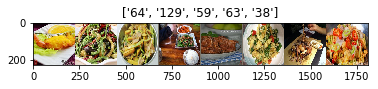

In [26]:
ut = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

# imshow(out, title=[dset_classes[x] for x in preds_try.data.cpu()])

### Modifying the last layer and setting the gradient false to all layers

In [27]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

![vgg16](https://mlelarge.github.io/dataflowr/Notebooks/vgg16.png)

Our goal is to use the already trained model and just change the number of output classes. To this end we replace the last nn.Linear layer trained for 1000 classes to ones with 172 classes. In order to freeze the weights of the other layers during training, we set the field required_grad=False. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 2 class layer will be updated.

In [28]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 172)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [29]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=172, bias=True)
  (7): LogSoftmax()
)


In [30]:
model_vgg = gpu(model_vgg)

### Calculating preconvoluted features

In [31]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        inputs = gpu(inputs)
        labels = gpu(labels)
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [32]:
x_try = model_vgg.features(inputs_try)

In [33]:
x_try.data.shape

torch.Size([5, 512, 7, 7])

In [34]:
labels_try

tensor([133,  33, 127, 132, 104], device='cuda:0')

In [35]:
labels_try.data

tensor([133,  33, 127, 132, 104], device='cuda:0')

In [36]:
torch.cuda.device_count()

2

In [37]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

CPU times: user 8min 53s, sys: 4min 39s, total: 13min 33s
Wall time: 13min 33s


In [38]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['val'])

CPU times: user 1min 27s, sys: 46.6 s, total: 2min 14s
Wall time: 2min 14s


In [39]:
# %%time
# conv_feat_test,labels_test = preconvfeat(dset_loaders['test'])

In [40]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]
    
%mkdir ./vgg16

In [41]:
save_array(os.path.join('./vgg16','feat_train.bc'),conv_feat_train)
save_array(os.path.join('./vgg16','labels_train.bc'),labels_train)
save_array(os.path.join('./vgg16','feat_val.bc'),conv_feat_val)
save_array(os.path.join('./vgg16','labels_val.bc'),labels_val)
# save_array(os.path.join('./vgg16','feat_test.bc'),conv_feat_test)
# save_array(os.path.join('./vgg16','labels_test.bc'),labels_test)

## Training fully connected module

### Loading Preconvoluted features

In [45]:
conv_feat_train = load_array('./vgg16/feat_train.bc')
labels_train = load_array('./vgg16/labels_train.bc')
conv_feat_val = load_array('./vgg16/feat_val.bc')
labels_val = load_array('./vgg16/labels_val.bc')
# conv_feat_test = load_array(data_dir+'/vgg16/conv_feat_test.bc')
# labels_test = load_array(data_dir+'/vgg16/labels_test.bc')

In [46]:
criterion = nn.NLLLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Creating Data generator

In [47]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [54]:
def train_model(model,size_train,size_val,conv_feat_train=None,labels_train=None, conv_feat_val=None,labels_val=None, epochs=1,optimizer=None,train=True,shuffle=True):
    if train:
        model.train()
    else:
        model.eval()
        
    LOSS = []
    ACC = []
    LOSS_V = []
    ACC_V = []
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat_train,labels=labels_train,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            inputs , classes = gpu(torch.from_numpy(inputs)), gpu(torch.from_numpy(classes))
#             print(inputs.size())
            inputs = inputs.view(inputs.size(0), -1)
#             print(inputs.size())
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size_train
        epoch_acc = running_corrects.data.item() / size_train
        LOSS.append(epoch_loss)
        ACC.append(epoch_acc)
        print('Epoch: {} Training Loss: {:.4f} Training Acc: {:.4f}'.format(
                     epoch+1, epoch_loss, epoch_acc))
        
        batches = data_gen(conv_feat=conv_feat_val,labels=labels_val,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            inputs , classes = gpu(torch.from_numpy(inputs)), gpu(torch.from_numpy(classes))
                            
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes) 
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size_val
        epoch_acc = running_corrects.data.item() / size_val
        LOSS_V.append(epoch_loss)
        ACC_V.append(epoch_acc)
        print('Epoch: {} Validation Loss: {:.4f} Validation Acc: {:.4f}'.format(
                     epoch+1, epoch_loss, epoch_acc))
        
#     return 
    return LOSS, ACC, LOSS_V, ACC_V

In [49]:
%%time
LOSS, ACC, LOSS_V, ACC_V = (train_model(model=gpu(model_vgg.classifier),
            size_train=dset_sizes['train'],size_val=dset_sizes['val'],
            conv_feat_train=conv_feat_train,labels_train=labels_train,
            conv_feat_val=conv_feat_val,labels_val=labels_val,
            epochs=50,optimizer=optimizer_vgg,train=True,shuffle=True))

Epoch: 1 Training Loss: 0.0506 Training Acc: 0.3062
Epoch: 1 Validation Loss: 0.0399 Validation Acc: 0.4112
Epoch: 2 Training Loss: 0.0368 Training Acc: 0.4367
Epoch: 2 Validation Loss: 0.0356 Validation Acc: 0.4509
Epoch: 3 Training Loss: 0.0337 Training Acc: 0.4710
Epoch: 3 Validation Loss: 0.0340 Validation Acc: 0.4656
Epoch: 4 Training Loss: 0.0322 Training Acc: 0.4853
Epoch: 4 Validation Loss: 0.0329 Validation Acc: 0.4793
Epoch: 5 Training Loss: 0.0310 Training Acc: 0.5007
Epoch: 5 Validation Loss: 0.0321 Validation Acc: 0.4861
Epoch: 6 Training Loss: 0.0304 Training Acc: 0.5071
Epoch: 6 Validation Loss: 0.0316 Validation Acc: 0.4902
Epoch: 7 Training Loss: 0.0297 Training Acc: 0.5158
Epoch: 7 Validation Loss: 0.0313 Validation Acc: 0.4985
Epoch: 8 Training Loss: 0.0292 Training Acc: 0.5212
Epoch: 8 Validation Loss: 0.0312 Validation Acc: 0.4954
Epoch: 9 Training Loss: 0.0287 Training Acc: 0.5293
Epoch: 9 Validation Loss: 0.0309 Validation Acc: 0.4985
Epoch: 10 Training Loss: 0.0

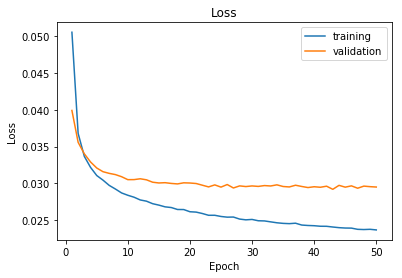

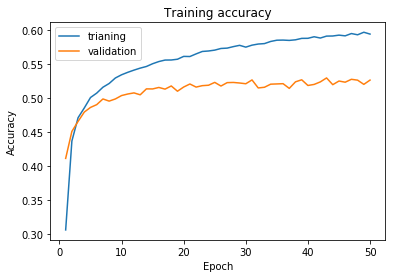

In [52]:
plt.figure()
E = np.arange(50)+1
plt.plot(E,LOSS,label='training')
plt.plot(E,LOSS_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(E,ACC,label='trianing')
plt.plot(E,ACC_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()
plt.show()

In [53]:
correct = 0
total = 0
with torch.no_grad():
    for data in dset_loaders['test']:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the all test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the all test images: 52 %


In [ ]:
# Get a batch of test data
inputs, classes = next(iter(dset_loaders['test']))

out = torchvision.utils.make_grid(inputs[0:n_images])

print("Ground Truth")
imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])